In [20]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.sparse import hstack, vstack
from matplotlib import pyplot as plt
import seaborn as sns

# Извлечение данных

In [21]:
!wget -P /content/data https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv
data_path = 'data/fake_news.csv'
df = pd.read_csv(data_path,index_col='Unnamed: 0')
df.head()

--2024-12-07 16:03:48--  https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30696129 (29M) [text/csv]
Saving to: ‘/content/data/fake_news.csv.2’

fake_news.csv.2     100%[===================>]  29.27M  16.6MB/s    in 1.8s    

2024-12-07 16:03:50 (16.6 MB/s) - ‘/content/data/fake_news.csv.2’ saved [30696129/30696129]



,title,text,label
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6335 entries, 8476 to 4330
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 198.0+ KB


# Деление трейн-тест

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df[['title','text']],df['label'],test_size=0.25,stratify=df['label'])

# Модель
## Создание

In [29]:
def fit_some_vectorizer_from_dataframe(df):
    X = {}
    vectorizers = {}
    for name in df:
        vectorizers[name] = TfidfVectorizer().fit(df[name])
    return vectorizers

class fake_news_model(BaseEstimator, ClassifierMixin):
    def __init__(self,max_df=1.0,min_df=1):
        self._params = {'max_df':max_df, 'min_df':min_df}
        self.vectorizers_title = None#TfidfVectorizer(max_df=max_df,min_df=min_df)
        self.vectorizers_text = None#TfidfVectorizer(max_df=max_df,min_df=min_df)
        self.model = PassiveAggressiveClassifier()

    def _prepare(self,df):
        X_list = []
        if self.vectorizers_title is None:
            self.vectorizers_title = TfidfVectorizer(**self._params).fit(df['title'])
            self.vectorizers_text = TfidfVectorizer(**self._params).fit(df['text'])
        X_title = self.vectorizers_title.transform(df['title'])
        X_text = self.vectorizers_text.transform(df['text'])
        X = hstack([X_title,X_text])
        return X

    def fit(self,X,y):
        X = self._prepare(X)
        self.model.fit(X,y)
        return self

    def partial_fit(self,X,y,classes):
        X = self._prepare(X)
        self.model.partial_fit(X,y,classes)
        return self

    def predict(self,features_df):
        X = self._prepare(features_df)
        return self.model.predict(X)


## Подбор гиперпараметров

## Обучение
С имитацией онлайн обучения

In [32]:
n_splits = 5

indices_shuffled = np.random.permutation(X_train.index)
indices_samples = np.array_split(indices_shuffled, n_splits)

mdl = fake_news_model()
for sample in indices_samples:
    X_splits = X_train.loc[sample]
    y_splits = y_train.loc[sample]
    mdl.partial_fit(X_splits,y_splits,classes=y_train.unique())


## Проверка

In [33]:
y_pred = mdl.predict(X_test)

In [35]:
print('Точность предсказаний: %.2f' % accuracy_score(y_test,y_pred))

Точность предсказаний: 0.91


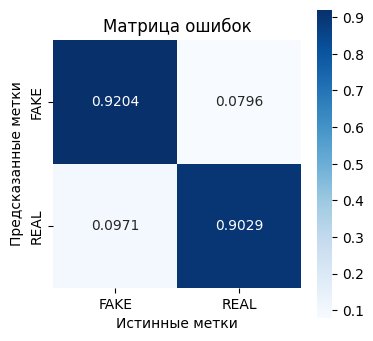

In [37]:
def show_confusion_matrix(y_true,y_pred):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    n = len(pd.unique(y_true))
    plt.figure(figsize=(n*2,n*2))
    confusion_normalized = confusion_matrix(y_true,y_pred,normalize='true')
    axis_labels = sorted(np.unique(y_test))
    ax = sns.heatmap(
        confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.4f', square=True)
    plt.title("Матрица ошибок")
    plt.xlabel("Истинные метки")
    plt.ylabel("Предсказанные метки")
show_confusion_matrix(y_test,y_pred)